In [1]:
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from scipy.stats import ttest_ind
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math

warnings.filterwarnings('ignore')
%matplotlib inline
palette1 = "#007BFF"
palette2 = "#3ABFC2"
palette3 = "#E1C081"
palette4 = "#E17A57"
palette5 = "#D92D3F"

model_performance_csv = "replication/computer_vision_output_treatments.csv"
experiment_pilot = "replication/pilot.csv"
pilot_treat = "replication/pilot_treat.csv"
pilot_emo = "replication/pilot_emo.csv"
experiment1_prolific_csv = "replication/e1_prolific.csv"
experiment1_internet_csv = "replication/e1_internet.csv"

# Experiment 1 (2 AFC)

In [2]:
df = pd.read_csv(experiment_pilot)
treat = pd.read_csv(pilot_treat)
emotion = pd.read_csv(pilot_emo)
print("Unique participants: {}".format(df.user_id.nunique()))
print("Guesses: {}".format(df.shape[0]))
temp = pd.DataFrame(df.groupby("user_id").seen.max()).reset_index()
temp.columns = ["user_id","max_seen"]
df = pd.merge(df,temp,on="user_id")
df = df.sort_values(["user_id","time_created"], ascending=True)
df['t2'] = pd.to_datetime(df.groupby(['user_id'])['time_created'].shift(1))
df['time_created']=pd.to_datetime(df['time_created'])
df["delta"]=df.time_created-df.t2
df.delta = df.delta.dt.seconds
df = df[(df.delta<300) | (df.delta.isnull())]
df = df[(df.delta>10) | (df.delta.isnull())]
w = pd.merge(treat,df,on="user_id")
w['date'] = pd.to_datetime(w.time_created_y)
gf = w.groupby('user_id')['date'].rank(ascending=True)
w["rank2"] = gf
gf2 = pd.DataFrame(w.groupby("user_id").rank2.max()).reset_index()
gf2.columns = ['user_id','maxrank']
w = pd.merge(w,gf2,on="user_id")
n=10
w2 = w[(w.maxrank>=n)]
print("Participants who saw at least 10 pairs of videos: {}".format(w2.user_id.nunique()))
t1 = pd.DataFrame(w2.groupby(["rank2",'treatment_one']).correct.agg(["mean","count"])).reset_index()
t2 = pd.DataFrame(w2.groupby(["rank2",'treatment_two']).correct.agg(["mean","count"])).reset_index()
t3 = pd.DataFrame(w2.groupby(["rank2",'treatment_three']).correct.agg(["mean","count"])).reset_index()

print("Mean Accuracy (All Guesses): {}".format(w2[(w2.seen<3) | 
                                                               ((w2.seen<8) & (w2.seen>=5)) |
                                                               (w2.seen==9) |
                                                              (w2.seen==3) & (w2.treatment_two=='4') |
                                                              (w2.seen==4) & (w2.treatment_two=='3') ].groupby("user_id").correct.mean().mean()))
print("Percent Beating the Model's Performance:{}".format((w2[(w2.seen<3) | 
                                                               ((w2.seen<8) & (w2.seen>=5)) |
                                                               (w2.seen==9) |
                                                              (w2.seen==3) & (w2.treatment_two=='4') |
                                                              (w2.seen==4) & (w2.treatment_two=='3') ].groupby("user_id").correct.mean()>.65).sum()/w2.user_id.nunique()))
# print("N participants: {}".format(w2[(w2.seen<3) | 
#                                                                ((w2.seen<8) & (w2.seen>=5)) |
#                                                                (w2.seen==9) |
#                                                               (w2.seen==3) & (w2.treatment_two=='4') |
#                                                               (w2.seen==4) & (w2.treatment_two=='3') ]["user_id"].nunique()))

w2["real_one"] = [int("real" in i) for i in w2.imageone]
w2.loc[w2.real_one == 1, 'real'] = w2["imageone"]
w2.loc[w2.real_one == 0, 'real'] = w2["imagetwo"]

w2["fake_one"] = [int("fake" in i) for i in w2.imageone]
w2.loc[w2.real_one == 0, 'fake'] = w2["imageone"]
w2.loc[w2.real_one == 1, 'fake'] = w2["imagetwo"]
# dd = pd.get_dummies(w2.real)
w2['upsidedown'] = 0
w2.loc[(w2.treatment_two=='4') & (w2.seen==4), 'upsidedown'] = 1
w2.loc[(w2.treatment_two=='3') & (w2.seen==3), 'upsidedown'] = 1
w2.loc[(w2.seen==8), 'upsidedown'] = 1
x = pd.DataFrame(w2[["real","fake","correct"]].fake.value_counts().head(56)).reset_index()
x.columns = ["fake","count"]
test = pd.merge(w2[["real","fake","correct"]],x,on="fake")
x = pd.DataFrame(test.groupby("real").correct.agg(["mean","count"])).reset_index()
x.columns = ["real","correct","count"]
print(sum(x.correct>.83))
print(sum((x.correct>.65) & (x.correct<.83)))
print(sum(x.correct<.65))
print(sum(x.correct<.5))

Unique participants: 5524
Guesses: 26820
Participants who saw at least 10 pairs of videos: 882
Mean Accuracy (All Guesses): 0.7992900334737031
Percent Beating the Model's Performance:0.8242630385487528
28
16
12
3


In [3]:
w2["delta"].describe()

count    10674.000000
mean        52.858722
std         39.541800
min         11.000000
25%         27.000000
50%         42.000000
75%         65.000000
max        299.000000
Name: delta, dtype: float64

In [4]:
w2 = w2[w2.seen>0]
res1 = sm.OLS(w2['correct'], sm.add_constant(w2[['seen',"upsidedown", "delta", "treatment_three"]]), M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': w2.real})
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.66
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           8.76e-16
Time:                        12:45:40   Log-Likelihood:                -5685.2
No. Observations:               10673   AIC:                         1.138e+04
Df Residuals:                   10668   BIC:                         1.142e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8479      0.018     47.703      0.000       0.813       0.883
seen               -0.0007      0.000     -1.591      0.112      -0.002       0.000
upsidedown         -0.0566      0.020     -2.853      0.004      -0.095      -0.018
delta              -0.0011      0.000     -8.296      0.000      -0.001      -0.001
treatment_three     0.0044      0.008      0.537      0.592      -0.012       0.020
==============================================================================
Omnibus:                     1894.647   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3109.061
Skew:                          -1.319   Prob(JB):                         0.00
Kurtosis:                       2.824   Cond. No.                         246.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [5]:
w3 = pd.merge(w2,pd.get_dummies(w2.treatment_one), left_index=True,right_index=True)
res1 = sm.OLS(w3['correct'], sm.add_constant(w3[['upsidedown',"happy","anger","anxiety"]]), M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': w3.user_id})
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.829
Date:                Thu, 09 Dec 2021   Prob (F-statistic):            0.00430
Time:                        12:45:40   Log-Likelihood:                -5746.8
No. Observations:               10673   AIC:                         1.150e+04
Df Residuals:                   10668   BIC:                         1.154e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7866      0.007    106.185      0.000       0.772       0.801
upsidedown    -0.0562      0.015     -3.636      0.000      -0.086      -0.026
happy          0.0022      0.013      0.168      0.867      -0.024       0.028
anger         -0.0265      0.021     -1.257      0.209      -0.068       0.015
anxiety       -0.0084      0.014     -0.582      0.560      -0.036       0.020
==============================================================================
Omnibus:                     1940.851   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3217.470
Skew:                          -1.342   Prob(JB):                         0.00
Kurtosis:                       2.810   Cond. No.                         4.10
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [6]:
w4 = pd.merge(w3,emotion,on="user_id")
w4 = w4[["user_id","guess_y",'anger', 'anxiety', 'control_anger',
       'control_anxiety', 'control_happy', 'control_sad', 'happy', "treatment_one"]].drop_duplicates()

In [7]:
w4.guess_y
print("p-value of t-test: {}".format(ttest_ind(*w4[(w4.treatment_one=="anger") | (w4.treatment_one=="control_anger")].groupby('anger')['guess_y'].apply(lambda x:list(x)))[1]))
print("p-value of t-test: {}".format(ttest_ind(*w4[(w4.treatment_one=="anxiety") | (w4.treatment_one=="control_anxiety")].groupby('anxiety')['guess_y'].apply(lambda x:list(x)))[1]))
print("p-value of t-test: {}".format(ttest_ind(*w4[(w4.treatment_one=="happy") | (w4.treatment_one=="control_happy")].groupby('happy')['guess_y'].apply(lambda x:list(x)))[1]))


p-value of t-test: 0.0906701307625482
p-value of t-test: 0.5577544604965696
p-value of t-test: 0.19045333201114656


# Experiment 2 (Single Stimuli Design)

In [8]:
df2 = pd.read_csv(experiment1_prolific_csv)
df2_x = pd.read_csv(experiment1_internet_csv)
print(df2.prolific_pid.nunique())
print(df2[df2.guess_round==1].shape[0])
print(df2_x.user_id.nunique())
print(df2_x[df2_x.guess_round==1].shape[0])

print(df2_x[df2_x.guess_round==1].groupby("user_id").guess_int.count().mean())
print(df2_x[df2_x.guess_round==1].groupby("user_id").guess_int.count().quantile(.9))

304
6390
9188
67647
7.362538093164998
17.0


In [9]:
df2.groupby("prolific_pid").video.nunique().sort_values().head(10)

prolific_pid
5f47f19248a89010ebae8705    20
5f5023517ef2f019cf3ebb57    20
5d7af4ee784e52001b9b02da    20
5ed559e5afbd830e2117ed55    21
5ec9c63eee4ab64e55a16e4a    21
5ec4c385295d6e3b97b158be    21
5eba16aa359030156a6d5d31    21
5eb2337f63326f1870b44fc6    21
5eaf82885cd77a69057b398f    21
546e3778fdf99b2bc7ebcff6    21
Name: video, dtype: int64

### Individual vs. Machine

In [10]:
sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
sample2 = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
sample1_fake = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==1)]
sample2_fake = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==1)]
sample1_real = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==0)]
sample2_real = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==0)]



n = 0
k = 45
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print(sample1.human_correct_guess.mean())
print(sample1_x.human_correct_guess.mean())
n = 10
k = 10
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print(sample1_x.human_correct_guess.mean())
print(sample1.groupby("video").computer_correct_guess.mean().mean())


0.6639871382636656
0.6859204304581771
0.7182905556939945
0.8


In [11]:
temp=pd.DataFrame(df2[(df2.guess_round==1) &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)].groupby("prolific_pid")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for DFDC videos".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))


n = 10
k = 45
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
temp=pd.DataFrame(sample1_x.groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for DFDC videos".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))

n = 1
k = 10
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
temp=pd.DataFrame(sample1_x.groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for DFDC videos".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))

13.100436681222707% humans outperform the computer for DFDC videos
26.82277807344332% humans outperform the computer for DFDC videos
37.271126760563384% humans outperform the computer for DFDC videos


In [12]:
print(sample1_fake.human_correct_guess.mean())
print(sample1_real.human_correct_guess.mean())
print(sample1_real.groupby("video").computer_correct_guess.mean().mean())
print(sample1_fake.groupby("video").computer_correct_guess.mean().mean())
print("\n")
print((sample1.guess_int<50).mean())
print((sample1.guess_int>50).mean())
print((sample1.guess_int==50).mean())

print((sample1.c_score<.50).mean())
sample1c = sample1.groupby("video")[["c_score","fake"]].mean().reset_index()
print((((sample1c.c_score>.50) & (sample1c.fake==1))|((sample1c.c_score<.50) & (sample1c.fake==0))).mean())
print((((sample1c.c_score>.50) & (sample1c.fake==0))|((sample1c.c_score<.50) & (sample1c.fake==1))).mean())
print((sample1.c_score==.50).mean())

0.5666666666666667
0.7546583850931677
0.76
0.84


0.5683279742765274
0.3842443729903537
0.04742765273311897
0.06028938906752412
0.44
0.42
0.13906752411575563


In [13]:
temp=pd.DataFrame(df2[(df2.guess_round==1) &
     (df2.assignment=="control") & ((df2.video=="Putin_10s_b.mp4") | (df2.video=="Putin_10s_a.mp4") 
    | (df2.video=="Kim_10s_b.mp4") | (df2.video=="Kim_10s_a.mp4")) & (df2.pass_check_binary==1)].groupby("prolific_pid")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))

n = 10
k = 45
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
temp=pd.DataFrame(df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen<=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & ((df2_x.video=="Putin_10s_b.mp4") | (df2_x.video=="Putin_10s_a.mp4") 
    | (df2_x.video=="Kim_10s_b.mp4") | (df2_x.video=="Kim_10s_a.mp4"))].groupby("user_id")[['score','c_score']].mean()).reset_index()
temp.columns = ["prolific_pid","mean_h_score","mean_c_score"]
print("{}% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin".format(100*sum(temp.mean_h_score>temp.mean_c_score)/temp.shape[0]))
print(list(df2[df2.video=="Kim_10s_a.mp4"]['c_score'])[0])
print(list(df2[df2.video=="Putin_10s_a.mp4"]['c_score'])[0])
print(list(df2[df2.video=="v2attentioncheck.mp4"]['c_score'])[0])


60.0% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin
68.36461126005362% humans outperform the computer for videos of Kim Jung-Un and Vladimir Putin
0.018000000000000002
0.0846
0.012


In [14]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
fixed_effects = pd.get_dummies(df2.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["seen"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["seen"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const', "seen"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'seen':"Seen"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())

In [15]:
def get_delay(df2, kind):
    if kind == "prolific":
        df3=df2.sort_values(["prolific_pid","time_created_guess"], ascending=True)
        df3['t2']=pd.to_datetime(df3.groupby(['prolific_pid'])['time_created_guess'].shift(1))
        df3['time_created']=pd.to_datetime(df3['time_created_guess'])
    else:
        df3=df2.sort_values(["user_id","time_created"], ascending=True)
        df3['t2']=pd.to_datetime(df3.groupby(['user_id'])['time_created'].shift(1))
        df3['time_created']=pd.to_datetime(df3['time_created'])
    # df=df[df.t2.notnull()]
    df3["delta"]=df3.time_created-df3.t2
    df3.delta = df3.delta.dt.seconds
    print(df3[(df3.guess_round==1) & (df2.seen<=20)].delta.describe())
    print(df3[(df3.guess_round==2) & (df2.seen<=20)].delta.describe())

    df3 = df3[df3.delta<120]
    return df3

exp2a = get_delay(pd.read_csv(experiment1_prolific_csv),"prolific")
exp2b = get_delay(pd.read_csv(experiment1_internet_csv),"internet")

fixed_effects = pd.get_dummies(exp2a.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c]):
    if index<3:
        columns = ["delta"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    else:
        columns = ["delta"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
    
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet"], [3,3])
stargazer.covariate_order(['const', "delta"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'delta':"Delay"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())


count     6086.000000
mean        33.687644
std        193.247482
min          0.000000
25%         17.000000
50%         22.000000
75%         31.000000
max      11705.000000
Name: delta, dtype: float64
count    6378.000000
mean        4.745532
std         6.127315
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        99.000000
Name: delta, dtype: float64
count    52833.000000
mean        69.652149
std       1367.584197
min          0.000000
25%         15.000000
50%         21.000000
75%         30.000000
max      84904.000000
Name: delta, dtype: float64
count    61553.000000
mean         5.020032
std        105.860920
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      17728.000000
Name: delta, dtype: float64


Text(0, 0.5, 'Accuracy')

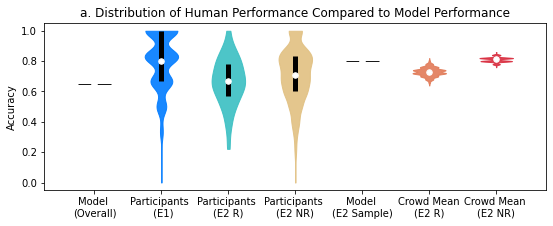

In [16]:
sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
n = 10
k = 50
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
# print(sample1_x.human_correct_guess.mean())
# print(sample1.groupby("video").computer_correct_guess.mean().mean())


count5 = df2.groupby(["prolific_pid","assignment"])['video'].count().reset_index()
count5 = count5[(count5.assignment=="control")].reset_index()
count5.columns = ["index","prolific_pid","a","control_views"]
count5 = count5[["prolific_pid","control_views"]]
sample1 = pd.merge(sample1,count5,on="prolific_pid",how="left")
sample1.control_views = sample1.control_views.fillna(0)

count5 = df2_x.groupby(["user_id","assignment"])['video'].count().reset_index()
count5 = count5[(count5.assignment=="control")].reset_index()
count5.columns = ["index","user_id","a","control_views"]
count5 = count5[["user_id","control_views"]]
# print(count5)
sample1_x = pd.merge(sample1_x,count5,on="user_id",how="left")
sample1_x.control_views = sample1_x.control_views.fillna(0)

e1_mean = w2[(w2.maxrank>9) & ((w2.seen<3) | ((w2.seen<8) & (w2.seen>=5)) |
(w2.seen==9) |
                                                              (w2.seen==3) & (w2.treatment_two=='4') |
                                                              (w2.seen==4) & (w2.treatment_two=='3') )].groupby("user_id").correct.mean().mean()
# print(e1_mean)
e1_bb = e1_mean = w2[(w2.maxrank>9) & ((w2.seen<3) | ((w2.seen<8) & (w2.seen>=5)) |
(w2.seen==9) |
                                                              (w2.seen==3) & (w2.treatment_two=='4') |
                                                              (w2.seen==4) & (w2.treatment_two=='3') )].groupby("user_id").correct.mean()
# aa = list(sample1[sample1.control_views>=10].groupby("prolific_pid").human_correct_guess.mean())
# ab = list(sample1_x[sample1_x.control_views>=10].groupby("user_id").human_correct_guess.mean())
# fig, ax = plt.subplots()
# ax.hist([i for i in e1_bb], bins=10, color=(58/255,191/255,194/255,.5), label="Participants (E1)", weights=np.ones(len(e1_bb)) / len(e1_bb))
# ax.hist([i for i in aa], bins=10, color=(0,123/255,255/255,.5), label="Participants (E2 – Prolific)", weights=np.ones(len(aa)) / len(aa))
# ax.hist([i for i in ab], bins=10,  color=(225/255,192/255,129/255,.5), label="Participants (E2 – Organic)", weights=np.ones(len(ab)) / len(ab))
# ax.axvline(x=.65, ymin=0, ymax=1, color=palette5, linewidth=3,
#           label="Model Mean (Overall)", alpha=.5)
# ax.axvline(x=sample1[sample1.control_views>=10].groupby("video").computer_correct_guess.mean().mean(), ymin=0, ymax=1, color=palette5, alpha=1, linewidth=3,
#           label="Model Mean (50 video sample)", linestyle=":")

# ax.axvline(x=.799, ymin=0, ymax=1, color=palette3, linewidth=3,
#           label="Participant Mean (E1)", alpha=.6, linestyle="-")
# ax.axvline(x=sample1[sample1.control_views>=10].human_correct_guess.mean(), ymin=0, ymax=1, color=palette1, linewidth=3,
#           label="Participant Mean (E2)", alpha=.4)

# plt.legend()
# plt.xlabel("Proportion Correct")
# plt.ylabel("Proportion of People")
# plt.title("a. Accuracy across Participants")
# # plt.yticks([0,5,10,15,20])

# plt.savefig("Figure1_a.png",dpi=300)
# plt.show()

e1_x = list(w2[(w2.maxrank>9) & ((w2.seen<3) | ((w2.seen<8) & (w2.seen>=5)) |
(w2.seen==9) |
                                                              (w2.seen==3) & (w2.treatment_two=='4') |
                                                              (w2.seen==4) & (w2.treatment_two=='3') )].groupby("user_id").correct.mean())


aa = list(sample1[sample1.control_views>=10].groupby("prolific_pid").human_correct_guess.mean())
bb = list(sample1_x[sample1_x.control_views>=10].groupby("user_id").human_correct_guess.mean())


# print(sample1.shape[0]/2)
# print(round(sample1_x.shape[0]/2,0))

e2pchecker = []
# print(sample1.shape)
for i in range(0,1000):
    e2pchecker.append(sum(sample1.sample(int(sample1.shape[0]/2)).groupby("video").human_correct_guess.mean()>.5)/50)
# print(np.mean(e2pchecker))
# print(np.max(e2pchecker))
# print(np.min(e2pchecker))

e2ochecker = []
# print(sample1_x.shape)
for i in range(0,1000):
    e2ochecker.append(sum(sample1_x.sample(int(round(sample1_x.shape[0]/2,0))).groupby("video").human_correct_guess.mean()>.5)/50)
# print(np.mean(e2ochecker))
# print(np.max(e2ochecker))
# print(np.min(e2ochecker))




def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
#     ax.set_xlabel('Leading Model and Participants')


# create test data
data = [[.65], sorted(e1_x), sorted(aa), sorted(bb), [.8], e2pchecker, e2ochecker]
# data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]

# fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)

# ax2.set_title('Human vs. AI Performance on Deepfake Detection')
# parts = ax2.violinplot(
#         data, showmeans=True, showmedians=False,
#         showextrema=False)

# for index, pc in enumerate(parts['bodies']):
# #     print(index)
#     if (index==0) | (index==4):
#         pc.set_facecolor(palette5)
#         pc.set_edgecolor(palette5)
#     elif index==1:
#         pc.set_facecolor(palette2)
#         pc.set_edgecolor(palette2)
#     else:
#         pc.set_facecolor(palette1)
#         pc.set_edgecolor(palette1)
    
#     pc.set_alpha(.5)

labels = ['Model \n(Overall)', 'Participants \n (E1)',
          'Participants \n(E2 Prolific)', 'Participants \n(E2 Organic)', 'Model \n(E2 Sample)',
          'Crown Mean\n(E2 Prolific)', 'Crowd Mean \n(E2 Organic)']
# for ax in [ax2]:
#     set_axis_style(ax, labels)

# plt.subplots_adjust(bottom=0.15, wspace=0.75)


a = list([.65])
b = list(sorted(e1_x))
c = list(sorted(aa))
d = list(sorted(bb))
e = list([.8])
f = list(e2pchecker)
g = list(e2ochecker)


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    
xpalette1 = "#000000"
xpalette2 = palette1
xpalette3 = palette2
xpalette4 = palette3
xpalette5 = "#000000"
xpalette6 = palette4
xpalette7 = palette5


# create test data
data = [a,b,c,d,e,f,g]
# data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]

fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)

ax2.set_title("a. Distribution of Human Performance Compared to Model Performance")
parts = ax2.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

for index, pc in enumerate(parts['bodies']):
#     print(index)
    if (index==0):
        pc.set_facecolor(xpalette1)
        pc.set_edgecolor(xpalette1)
    elif index==1:
        pc.set_facecolor(xpalette2)
        pc.set_edgecolor(xpalette2)
    elif index==2:
        pc.set_facecolor(xpalette3)
        pc.set_edgecolor(xpalette3)
    elif index==3:
        pc.set_facecolor(xpalette4)
        pc.set_edgecolor(xpalette4)
    elif index==4:
        pc.set_facecolor(xpalette5)
        pc.set_edgecolor(xpalette5)
    elif index==5:
        pc.set_facecolor(xpalette6)
        pc.set_edgecolor(xpalette6)
    elif index==6:
        pc.set_facecolor(xpalette7)
        pc.set_edgecolor(xpalette7)
    
    pc.set_alpha(.9)
inds = [1,2,3,4,5,6,7]
means = []
quartile1 = []
quartile3 = []
for x in data:
    means.append(np.mean(x))
    quartile1.append(np.quantile(x,.25))
    quartile3.append(np.quantile(x,.75))
ax2.scatter(inds, means, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
# ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


labels = ['Model \n(Overall)', 'Participants \n (E1)',
          'Participants \n(E2 R)', 'Participants \n(E2 NR)', 'Model \n(E2 Sample)',
          'Crowd Mean\n(E2 R)', 'Crowd Mean \n(E2 NR)']
for ax in [ax2]:
    set_axis_style(ax, labels)

plt.subplots_adjust(bottom=0.30, wspace=0.75)
plt.ylabel("Accuracy")
# plt.savefig("figures/violin_original.eps", dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


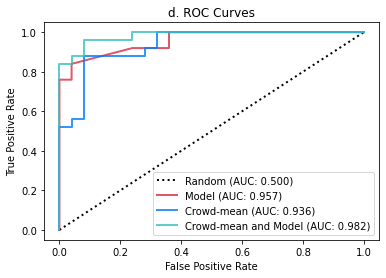

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

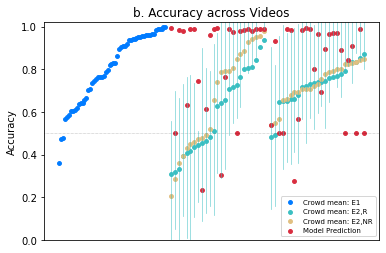

In [17]:
def video(df2, df2_x, attention="check"):
    if attention=="check":
        df2 = df2[df2.pass_check_binary==1]
        g1 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control")].groupby("video")['score','human_correct_guess',"guess_int",'fake',"p"].mean()).reset_index()
        g2 = pd.DataFrame(df2[(df2.guess_round==2) & (df2.assignment=="control")].groupby("video")["score",'human_correct_guess','guess_int'].mean()).reset_index()
        g75 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control")].groupby("video")["score",'human_correct_guess','guess_int'].quantile(.25)).reset_index()
        g25 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control")].groupby("video")["score",'human_correct_guess','guess_int'].quantile(.75)).reset_index()
        g25.columns = ["video","g25_score","g25_accuracy", "g25_confidence"]
        g75.columns = ["video","g75_score","g75_accuracy", "g75_confidence"]
        df2_x = df2_x[df2_x.pass_check_binary==1]
        g1_x = pd.DataFrame(df2_x[(df2_x.guess_round==1) & (df2_x.assignment=="control")].groupby("video")['score','human_correct_guess',"guess_int",'fake',"p"].mean()).reset_index()
        g1_x = g1_x[(g1_x.video!="Putin_10s_b.mp4") & (g1_x.video!="Putin_10s_a.mp4") & (g1_x.video!="Kim_10s_b.mp4") & (g1_x.video!="Kim_10s_a.mp4") &  (g1_x.video!="v2attentioncheck.mp4")]
    else:
        g1 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control") ].groupby("video")['score','human_correct_guess',"guess_int",'fake',"p"].mean()).reset_index()
        g2 = pd.DataFrame(df2[(df2.guess_round==2) & (df2.assignment=="control") ].groupby("video")["score",'human_correct_guess','guess_int'].mean()).reset_index()
    g1.columns = ["video",'g1_score',"g1_accuracy","g1_confidence","fake", "c_prediction"]
    g1_x.columns = ["video",'g1_score',"g1_accuracy","g1_confidence","fake", "c_prediction"]
    g2.columns = ["video","g2_score","g2_accuracy", "g2_confidence"]
    g = pd.merge(g1,g2,on="video").sort_values("g1_confidence")
    g = g[["video","fake", "c_prediction","g1_score","g1_confidence","g2_score","g2_accuracy","g1_accuracy","g2_confidence"]]
    g["c_score"] = g["c_prediction"]
    g.loc[(g.fake == 0),'c_score']=1-g.c_score
    g["ggg1_accuracy"] = g["g1_accuracy"]
    g.loc[(g.fake == 0),'ggg1_accuracy']=1-g.g1_accuracy
    video_all = g[(g.video!="v2attentioncheck.mp4")]
    video_dfdc = g[(g.video!="Putin_10s_b.mp4") & (g.video!="Putin_10s_a.mp4") & (g.video!="Kim_10s_b.mp4") & (g.video!="Kim_10s_a.mp4") &  (g.video!="v2attentioncheck.mp4")]
    
    c_fpr, c_tpr, thresholds = roc_curve(video_dfdc.fake, video_dfdc.c_prediction)
    c_auc = roc_auc_score(video_dfdc.fake, video_dfdc.c_prediction)
#     print(thresholds)
    h_fpr, h_tpr, thresholds = roc_curve(video_dfdc.fake, video_dfdc.g1_confidence/100)
#     print(thresholds)
    h_auc = roc_auc_score(video_dfdc.fake, video_dfdc.g1_confidence)
    hc_fpr, hc_tpr, thresholds = roc_curve(video_dfdc.fake, video_dfdc.g2_confidence)
#     print(thresholds)
    hc_auc = roc_auc_score(video_dfdc.fake, video_dfdc.g2_confidence)
#     print(c_fpr)
#     plt.plot([0,.1,.2,.5,.8,1], [0,.1,.2,.5,.8,1], label='Random (AUC: {:0.2f})'.format(.5), color=palette3, alpha=1, linestyle="dotted")
#     plt.plot(c_fpr, c_tpr, label='Computer (AUC: {:0.2f})'.format(c_auc), color=palette5, alpha=.8)
#     plt.plot(h_fpr, h_tpr, label='Human (AUC: {:0.2f})'.format(h_auc), color=palette1, alpha=.8)
# #     plt.plot(hc_fpr, hc_tpr, label='Human + Computer (AUC: {:0.2f})'.format(hc_auc), color=palette2, alpha=.8)
#     plt.legend()
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title ("ROC Curve")
#     plt.savefig("roc_a_{}_{}_{}.png".format(pp, n, attention),dpi=300)
#     plt.show()
    
    plt.plot([0,.1,.2,.5,.8,1], [0,.1,.2,.5,.8,1], label='Random (AUC: {:0.3f})'.format(.5), color="black", alpha=1, linestyle="dotted", linewidth=2)
    plt.plot(c_fpr, c_tpr, label='Model (AUC: {:0.3f})'.format(c_auc), color=palette5, alpha=.8, linewidth=2)
    plt.plot(h_fpr, h_tpr, label='Crowd-mean (AUC: {:0.3f})'.format(h_auc), color=palette1, alpha=.8, linewidth=2)
    plt.plot(hc_fpr, hc_tpr, label='Crowd-mean and Model (AUC: {:0.3f})'.format(hc_auc), color=palette2, alpha=.8, linewidth=2)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title ("d. ROC Curves")
    plt.savefig("Figure1_d.eps",dpi=600)
    plt.show()


    g["c_rank"]=g.c_score.rank(method="first")
    g["h_rank"]=g.g1_score.rank(method="first")
    g["ha_rank"]=g.g1_accuracy.rank(method="first")
    g = video_dfdc
    fig, ax1 = plt.subplots()
    g["c_rank"]=g.c_score.rank(method="first")
    g["h_rank"]=g.g1_score.rank(method="first")
    g["ha_rank"]=g.g1_accuracy.rank(method="first")
    gfrank = pd.DataFrame(g.groupby("fake").g1_score.rank())
    gfrank_x = pd.DataFrame(g1_x.groupby("fake").g1_score.rank())
    g1_x = pd.merge(g1_x,gfrank_x,left_index=True,right_index=True)
    g1_x.g1_score_y = g1_x.g1_score_y+28
    g1_x.loc[(g1_x.fake == 0),'g1_score_y']=26+g1_x.g1_score_y
    g = pd.merge(g,gfrank,left_index=True, right_index=True)
    g.g1_score_y = g.g1_score_y+28
    g.loc[(g.fake == 0),'g1_score_y']=26+g.g1_score_y
    
    
    e1_bb = w2[(w2.seen<3) | ((w2.seen<8) & (w2.seen>=5)) |
    (w2.seen==9) |
                                                                  (w2.seen==3) & (w2.treatment_two=='4') |
                                                                  (w2.seen==4) & (w2.treatment_two=='3') ]
    e_fix = e1_bb.groupby("real").user_id.count().reset_index().sort_values("user_id", ascending=False).head(56)
    e1_cc = pd.merge(e_fix,e1_bb,on="real")
    e1_cc_all = e1_cc.groupby("real").correct.mean()
#     e1_cc_all.columns = ["index1","real","correct"]
#     e1_25 = e1_cc.groupby("real").correct.quantile(.49)
#     e1_25.columns = ["real","correct25"]
#     e1_75 = e1_cc.groupby("real").correct.quantile(.75)
#     e1_75.columns = ["real","correct75"]
#     e1_cc_all = pd.merge(e1_cc_all,e1_25, on="real")
#     e1_cc_all = pd.merge(e1_cc_all,e1_75, on="real")
    e1_cc_all = e1_cc_all.reset_index().sort_values("correct").reset_index()
    e1_cc_all["index"] = e1_cc_all.index/2
#     print(e1_cc_all)
    
    g = pd.merge(g,g25,on="video")
    g = pd.merge(g,g75,on="video")
    
    plt.title("b. Accuracy across Videos")
    plt.ylabel('Accuracy')
    plt.xticks([])
#     plt.xlabel('Video Index')
    ax1.scatter( e1_cc_all["index"], e1_cc_all.correct, label="Crowd mean: E1", color=palette1, s=15)
    ax1.scatter(g.g1_score_y, g.g1_score_x, label="Crowd mean: E2,R", color=palette2, s=15)
    ax1.scatter(g1_x.g1_score_y, g1_x.g1_score_x, label="Crowd mean: E2,NR", color=palette3, s=15)
    ax1.scatter(g.g1_score_y, g.c_score, label="Model Prediction", color=palette5, s=15)
    
#     ax1.scatter(g[g.fake==0 & (g.video.str.contains("10s")==False)].g1_score_y, g[g.fake==0].c_score, label="Computer (Real)", color=palette5)
#     ax1.scatter(g[g.fake==0].g1_score_y, g[g.fake==0].g1_score_x, label="Participants (Real)", color=palette1)
    ax1.axhline(y=0.5, xmin=0.0, xmax=1.0, color="black",linewidth=.5, alpha=.5, linestyle="dotted")
    plt.ylim(0,1.02)
#     ax1.axvline(x=g.g1_score_y,ymin=g.g25_score, ymax=g.g75_score)
    for i in g.iterrows():
# #         print(i[1]["g1_score_y"],i[1]["g1_score_x"],i[1]["c_score"])
#         ax1.axvline(x=i[1]["g1_score_y"], ymin=i[1]["g1_score_x"]-.01, ymax=i[1]["c_score"]-.01, color="black",linewidth=.5, alpha=.25)
        ax1.axvline(x=i[1]["g1_score_y"], ymin=i[1]["g25_score"], ymax=i[1]["g75_score"], color=palette2,linewidth=.75, alpha=.65)
    plt.legend(prop={'size': 7}, loc="lower right")
    plt.savefig("Figure1_b.eps",dpi=600)
    plt.show()
#     print(e1_cc_all)
    return video_dfdc, h_fpr, h_tpr, thresholds

# df.sort_values(["prolific_pid","seen","guess_round"])
# df["guess_int_2"] = df.guess_int.shift(-1)
# # df = df[(df.guess_round==1)]
# df = df[(df.guess_round==1)] #& (df.treatment_x=="control")]
# df["update"] = (df["guess_int"] - df["guess_int_2"])
# df.loc[(df.fake == 1),'update']= -1*df["update"]
# df["computer_score"] = round(df.c_score*100,0)
g, fpr, tpr, thresh = video(df2, df2_x, "check")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

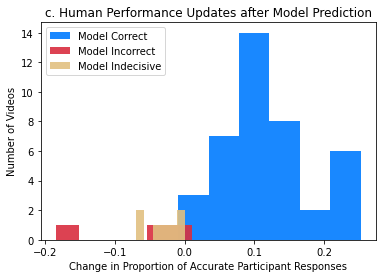

In [18]:
dft=df2
dft.sort_values(["prolific_pid","seen","guess_round"])
dft["guess_int_2"] = dft.guess_int.shift(-1)
# df = df[(df.guess_round==1)]
dft = dft[(dft.guess_round==1)] #& (df.treatment_x=="control")]
dft["update"] = (dft["guess_int"] - dft["guess_int_2"])
dft.loc[(dft.fake == 1),'update']= -1*dft["update"]
dft["computer_score"] = round(dft.c_score*100,0)

sample = dft[["prolific_pid","video","score","guess_int","guess_int_2","update","fake", "computer_score"]]

# sample.sort_values(["user_id","video"])
sample = sample.sort_values(["prolific_pid","video"])
sample["correct_1"] = (sample.guess_int>50).astype(int)
sample.loc[(sample.fake == 0),'correct_1']= (sample.guess_int<50).astype(int)
sample["correct_2"] = sample.guess_int_2>50
# sample = sample[sample["guess_int"]!=50]
sample.loc[(sample.fake == 0),'correct_2']= sample.guess_int_2<50
# updates = sample[["correct_1","correct_2","computer_score","video","fake","user_id","guess_int","guess_int_2"]].groupby(["user_id","video"]).mean().reset_index()
updates = sample[["correct_1","correct_2","computer_score","video","fake","prolific_pid","guess_int","guess_int_2"]].groupby(["prolific_pid","video"]).mean().reset_index()
updates["update"] = updates.correct_2 - updates.correct_1
updates["update"].value_counts()

updates = updates.sort_values(["video","fake"], ascending=True)
updates["abs_update"] = (updates.guess_int-updates.guess_int_2).abs()
updates["initial_yes"] = updates.guess_int>50

updates2 = updates.groupby("video")[["update","computer_score"]].mean()
updates2 = updates2.reset_index()
updates2b = updates2[(updates2.video!="Putin_10s_b.mp4") & (updates2.video!="Putin_10s_a.mp4") 
    & (updates2.video!="Kim_10s_b.mp4") & (updates2.video!="Kim_10s_a.mp4") & (updates2.video!="v2attentioncheck.mp4")]

aa = list(updates2['update'])
fig, ax = plt.subplots()
ax.hist(updates2b[updates2b.computer_score>50]['update'], bins=6, color=palette1, alpha=.9, label="Model Correct")
ax.hist(updates2b[updates2b.computer_score<50]['update'], bins=6, color=palette5, alpha=.9, label= "Model Incorrect")

ax.hist(updates2b[updates2b.computer_score==50]['update'], bins=6, color=palette3, alpha=.9, label = "Model Indecisive")
# plt.scatter(updates["update"],updates["computer_score"],color=palette5)
plt.legend(loc="best")
plt.xlabel("Change in Proportion of Accurate Participant Responses")
plt.ylabel("Number of Videos")
plt.title("c. Human Performance Updates after Model Prediction")
plt.savefig("Figure1_c.eps",dpi=600)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

55 55 55
[1.60333333 0.60333333 0.59       0.57       0.565      0.554
 0.55222222 0.54625    0.54       0.53       0.52333333 0.52
 0.51333333 0.51125    0.502      0.5        0.49       0.48888889
 0.48545455 0.48375    0.472      0.45777778 0.45666667 0.4325
 0.43       0.39       0.37      ]
[1.94966667 0.94966667 0.51       0.49516129 0.32026316 0.31808511
 0.31583333 0.27608696 0.26755556 0.09897436]
[1.94966667 0.94966667 0.619      0.54421053 0.504      0.499
 0.292      0.2584375  0.25259259 0.154      0.1475     0.01571429]


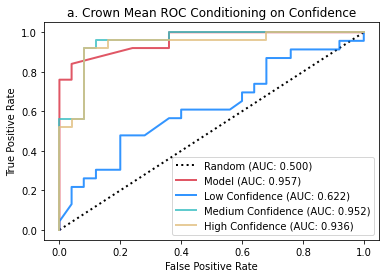

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

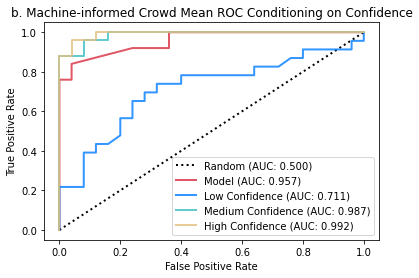

In [19]:
def wickes(df2, attention="check"):
    if attention=="check":
        df2 = df2[df2.pass_check_binary==1]
        g1 = pd.DataFrame(df2[(df2.guess_round==1) & (df2.assignment=="control")].groupby("video")['score','human_correct_guess',"guess_int",'fake',"p"].mean()).reset_index()
        g2 = pd.DataFrame(df2[(df2.guess_round==2) & (df2.assignment=="control")].groupby("video")["score",'human_correct_guess','guess_int'].mean()).reset_index()
    g1.columns = ["video",'g1_score',"g1_accuracy","g1_confidence","fake", "c_prediction"]
    g2.columns = ["video","g2_score","g2_accuracy", "g2_confidence"]
    g = pd.merge(g1,g2,on="video").sort_values("g1_confidence")
    g = g[["video","fake", "c_prediction","g1_score","g1_confidence","g2_score","g2_accuracy","g1_accuracy","g2_confidence"]]
    g["c_score"] = g["c_prediction"]
    g.loc[(g.fake == 0),'c_score']=1-g.c_score
    g["ggg1_accuracy"] = g["g1_accuracy"]
    g.loc[(g.fake == 0),'ggg1_accuracy']=1-g.g1_accuracy
    video_dfdc = g[(g.video!="Putin_10s_b.mp4") & (g.video!="Putin_10s_a.mp4") & (g.video!="Kim_10s_b.mp4") & (g.video!="Kim_10s_a.mp4") &  (g.video!="v2attentioncheck.mp4")]
    return video_dfdc, df2["video"].nunique()

low, l = wickes(df2[(df2.guess_int>33.5) & (df2.guess_int<66.5)],"check")
medium, m = wickes(df2[((df2.guess_int<33.5) | (df2.guess_int>66.5)) & ((df2.guess_int<83)| (df2.guess_int>17))],"check")
high, h = wickes(df2[(df2.guess_int<=17) | (df2.guess_int>=83)],"check")

print(l,m,h)
l_fpr, l_tpr, thresholds = roc_curve(low.fake, low.g1_confidence/100)
l_auc = roc_auc_score(low.fake, low.g1_confidence)
print(thresholds)
m_fpr, m_tpr, thresholds = roc_curve(medium.fake, medium.g1_confidence/100)
m_auc = roc_auc_score(medium.fake, medium.g1_confidence)
print(thresholds)
h_fpr, h_tpr, thresholds = roc_curve(high.fake, high.g1_confidence/100)
h_auc = roc_auc_score(high.fake, high.g1_confidence)
print(thresholds)

c_fpr, c_tpr, thresholds = roc_curve(high.fake, high.c_prediction)
c_auc = roc_auc_score(high.fake, high.c_prediction)


# hc_fpr, hc_tpr, thresholds = roc_curve(low.fake, video_dfdc.g2_confidence)
# hc_auc = roc_auc_score(video_dfdc.fake, low.g2_confidence)

plt.plot([0,.1,.2,.5,.8,1], [0,.1,.2,.5,.8,1], label='Random (AUC: {:0.3f})'.format(.5), color="black", alpha=1, linestyle="dotted", linewidth=2)
# plt.plot(c_fpr, c_tpr, label='Model (AUC: {:0.3f})'.format(c_auc), color=palette5, alpha=.8, linewidth=2)
plt.plot(c_fpr, c_tpr, label='Model (AUC: {:0.3f})'.format(c_auc), color=palette5, alpha=.8, linewidth=2)
plt.plot(l_fpr, l_tpr, label='Low Confidence (AUC: {:0.3f})'.format(l_auc), color=palette1, alpha=.8, linewidth=2)
plt.plot(m_fpr, m_tpr, label='Medium Confidence (AUC: {:0.3f})'.format(m_auc), color=palette2, alpha=.8, linewidth=2)
plt.plot(h_fpr, h_tpr, label='High Confidence (AUC: {:0.3f})'.format(h_auc), color=palette3, alpha=.8, linewidth=2)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title ("a. Crown Mean ROC Conditioning on Confidence")
plt.savefig("coc_roc_h.eps",dpi=600)
plt.show()

l_fpr, l_tpr, thresholds = roc_curve(low.fake, low.g2_confidence/100)
l_auc = roc_auc_score(low.fake, low.g2_confidence)

m_fpr, m_tpr, thresholds = roc_curve(medium.fake, medium.g2_confidence/100)
m_auc = roc_auc_score(medium.fake, medium.g2_confidence)

h_fpr, h_tpr, thresholds = roc_curve(high.fake, high.g2_confidence/100)
h_auc = roc_auc_score(high.fake, high.g2_confidence)


plt.plot([0,.1,.2,.5,.8,1], [0,.1,.2,.5,.8,1], label='Random (AUC: {:0.3f})'.format(.5), color="black", alpha=1, linestyle="dotted", linewidth=2)
plt.plot(c_fpr, c_tpr, label='Model (AUC: {:0.3f})'.format(c_auc), color=palette5, alpha=.8, linewidth=2)
plt.plot(l_fpr, l_tpr, label='Low Confidence (AUC: {:0.3f})'.format(l_auc), color=palette1, alpha=.8, linewidth=2)
plt.plot(m_fpr, m_tpr, label='Medium Confidence (AUC: {:0.3f})'.format(m_auc), color=palette2, alpha=.8, linewidth=2)
plt.plot(h_fpr, h_tpr, label='High Confidence (AUC: {:0.3f})'.format(h_auc), color=palette3, alpha=.8, linewidth=2)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title ("b. Machine-informed Crowd Mean ROC Conditioning on Confidence")
plt.savefig("coc_roc_hc.eps",dpi=600)
plt.show()
    
    

In [20]:
low = wickes(df2[(df2.guess_int>33.5) & (df2.guess_int<66.5)],"check")
medium = wickes(df2[((df2.guess_int<33.5) | (df2.guess_int>66.5)) & ((df2.guess_int<83)| (df2.guess_int>17))],"check")
high = wickes(df2[(df2.guess_int<=17) | (df2.guess_int>=83)],"check")




In [21]:
sample1["population"] = "prolific"
sample1_x["population"] = "internet"
# df_exp2 = sample1.append(sample1_x)
# df_exp2.to_csv("/Users/heart/Desktop/single-video.csv")

In [22]:
sample1 = df2[(df2.guess_round==1) &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]

sample2 = df2[(df2.guess_round==2) &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]

def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)

    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit

    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa

    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))

    return(out)
    
for s in [sample1, sample2]:
    hits = sum(s[s.fake==1].score>.5)
    crs = sum(s[s.fake==0].score>.5)
    fas = sum(s[s.fake==1].score<=.5)
    misses = sum(s[s.fake==0].score<=.5)
    Z = norm.ppf
    print(hits,misses,fas,crs)
    print(SDT(hits,misses,fas,crs))
    
s = sample1.groupby(["video","fake"]).c_score.max().reset_index()
hits = sum(s[s.fake==1].c_score>.5)
crs = sum(s[s.fake==0].c_score>.5)
fas = sum(s[s.fake==1].c_score<=.5)
misses = sum(s[s.fake==0].c_score<=.5)
Z = norm.ppf
print(hits,misses,fas,crs)
print(SDT(hits,misses,fas,crs))
qq = []
for p in sample1.prolific_pid.unique():
    s = sample1[sample1["prolific_pid"]==p]
    hits = sum(s[s.fake==1].score>.5)
    crs = sum(s[s.fake==0].score>.5)
    fas = sum(s[s.fake==1].score<=.5)
    misses = sum(s[s.fake==0].score<=.5)
    Z = norm.ppf
    try:
        qq.append(SDT(hits,misses,fas,crs)['d'])
    except ZeroDivisionError:
        pass
print(sum([i>1.7035 for i in qq])/len(qq))

613 279 456 784
{'d': 0.8258247569247099, 'beta': 0.9398859459283186, 'c': -0.07507251953713143, 'Ad': 0.7203717744245653}
736 252 333 809
{'d': 1.2073834849855838, 'beta': 0.9357995497074005, 'c': -0.05495684060610079, 'Ad': 0.8033779748132872}
21 6 4 19
{'d': 1.7035239906632902, 'beta': 1.1598558361283575, 'c': 0.08705232154525805, 'Ad': 0.8858159780733434}
0.12442396313364056


### Crowd Wisdom vs. Machine

In [23]:
sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]

sample2 = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]

print((sample1.groupby("video").score.mean()>.5).sum())
print((sample1.groupby("video").c_score.mean()>.5).sum())
n=0
k=50
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print((sample1_x.groupby("video").score.mean()>.5).sum())

n=10
k=50
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print((sample1_x.groupby("video").score.mean()>.5).sum())
print(sample1_x.user_id.nunique())

# y=[]
# y2=[]
# x = range(0,45)
# for i in range(0,45):
#     n=i
#     k=50
#     sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
#          (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
#         & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
#     y.append((sample1_x.groupby("video").score.mean()>.5).sum())
#     y2.append(sample1_x.user_id.nunique())
# plt.plot(x,y)

37
40
40
43
1879


In [24]:
sample1_z = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     ((df2.assignment=="control") | (df2.assignment=="attention_check")) & (df2.pass_check_binary==1)]

n=10
k=50
sample1_x_z = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     ((df2_x.assignment=="control") | (df2_x.assignment=="attention_check"))]


In [25]:
cm_r = sample1_z.groupby("video").score.mean().sort_values().reset_index()
cm_r.columns = ["video","Crowd Mean (Recruited)"]
cm_nr = sample1_x_z.groupby("video").score.mean().sort_values().reset_index()
cm_nr.columns = ["video","Crowd Mean (Non-recruited)"]
cm = pd.merge(cm_r,cm_nr,on="video")
cv = pd.read_csv(model_performance_csv)
cv = cv[["video","fake","control_score"]]
attention_check = pd.DataFrame({"video":["v2attentioncheck.mp4"],"fake":[1],"control_score":[.01]})
cv = cv.append(attention_check)
cm2 = pd.merge(cm,cv)
cm2 = cm2[["video","fake","Crowd Mean (Recruited)", "Crowd Mean (Non-recruited)","control_score"]]
cm2.columns = ["Video","Fake","Crowd Mean (Recruited)", "Crowd Mean (Non-recruited)","Leading Model"]
cm2['Video2'] = cm2.Video.str.replace(".mp4","")
cm2.loc[cm2.Video=="Kim_10s_a","Video2"] = "Jong-un"
cm2.loc[cm2.Video=="Kim_10s_b","Video2"] = "Jong-un"
cm2.loc[cm2.Video=="Putin_10s_a","Video2"] = "Putin"
cm2.loc[cm2.Video=="Putin_10s_b","Video2"] = "Putin"
cm2.loc[cm2.Video=="v2attentioncheck","Video2"] = "Attention Check"
cm2["Crowd Mean (Recruited)"] = round(cm2["Crowd Mean (Recruited)"],2)
cm2["Crowd Mean (Non-recruited)"] = round(cm2["Crowd Mean (Non-recruited)"],2)
cm2["Leading Model"] = round(cm2["Leading Model"],2)
cm2.to_csv("replication/Table3.csv",index=False)

In [26]:
# print(cm2[["Video2","Fake","Crowd Mean (Recruited)", "Crowd Mean (Non-recruited)","Leading Model"]].to_latex(index=False))

In [27]:
sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]

sample2 = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]

print((sample1.groupby("video").score.mean()>.5).sum())
print((sample1.groupby("video").c_score.mean()>.5).sum())
n=0
k=50
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print((sample1_x.groupby("video").score.mean()>.5).sum())

n=10
k=50
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
print((sample1_x.groupby("video").score.mean()>.5).sum())
print(sample1_x.user_id.nunique())

# y=[]
# y2=[]
# x = range(0,45)
# for i in range(0,45):
#     n=i
#     k=50
#     sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
#          (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
#         & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
#     y.append((sample1_x.groupby("video").score.mean()>.5).sum())
#     y2.append(sample1_x.user_id.nunique())
# plt.plot(x,y)

37
40
40
43
1879


### Video Features Correlated with Accuracy

In [28]:
vv = pd.read_csv("replication/computer_vision_human_comparison_with_annotations.csv")
vv_t = pd.read_csv("replication/Table3.csv")
vv_t.columns = ["video","fake","crowd_consensus_prolific","crowd_consensus_internet","computer_vision","v2"]
vv.computer_vision.round(2)
vv = vv[["video", 'grainy', 'floating distraction', 'dark',
       'flickering face', 'dark skin individual', 'blurry',
       'clear example of deepfake that people have trouble with', 'two people',
       'connection']]
vv = pd.merge(vv_t,vv,on="video")
vv.columns

vv = vv.fillna(0)
vv = vv[['video', 'crowd_consensus_prolific', 'computer_vision',
       'crowd_consensus_internet', 'grainy', 'floating distraction', 'dark',
       'flickering face', 'dark skin individual', 'blurry',
       'clear example of deepfake that people have trouble with', 'two people',
       'connection', 'fake']]
vv.columns = ['video', 'crowd_consensus_prolific', 'computer_vision',
        'crowd_consensus_internet', 'grainy', 'floating distraction', 'dark',
        'flickering face', 'dark skin individual', 'blurry',
        'clear example of deepfake that people have trouble with', 'two people',
        'connection', 'fake_zz']
print(vv.columns)
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
exp2a = pd.merge(exp2a,vv,on="video")
exp2b = pd.merge(exp2b,vv,on="video")
vv["c_guess"] = vv.fake_zz
vv.loc[(vv.computer_vision < .5),'c_guess']= -1*(vv.c_guess-1)
df2= exp2a

sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & ((df2.blurry==1) | (df2.grainy==1) | (df2.dark==1))]
print((sample1.groupby("video").score.mean()>.5).sum())
print((sample1.groupby("video").c_score.mean()>.5).sum())
print(sample1.video.nunique())
n=10
k=50
df2_x = exp2b
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4") & ((df2_x.blurry==1) | (df2_x.grainy==1) | (df2_x.dark==1))]
print((sample1_x.groupby("video").c_score.mean()>.5).sum())
print(sample1_x.video.nunique())

# print("xxx")

sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.blurry==0) & (df2.grainy==0) & (df2.dark==0)]
print((sample1.groupby("video").score.mean()>.5).sum())
print(sample1.video.nunique())
n=0
k=50
df2_x = exp2b
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4") & (df2_x.blurry==0) & (df2_x.grainy==0) & (df2_x.dark==0)]
print((sample1_x.groupby("video").score.mean()>.5).sum())
print(sample1_x.video.nunique())
n=10
k=50
df2_x = exp2b
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4") & (df2_x.blurry==0) & (df2_x.grainy==0) & (df2_x.dark==0)]
print((sample1_x.groupby("video").score.mean()>.5).sum())
print(sample1_x.video.nunique())
n=10
k=50
df2_x = exp2b
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4") & (df2_x.blurry==0) & (df2_x.grainy==0) & (df2_x.dark==0)]
print((sample1_x.groupby("video").c_score.mean()>.5).sum())
print(sample1_x.video.nunique())


exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==2) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==2) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==2) & (exp2a.pass_check_binary==1)]

e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c, 
                           vv,vv[vv.fake_zz==0],vv[vv.fake_zz==1],
                          vv,vv[vv.fake_zz==0],vv[vv.fake_zz==1],
                          vv,vv[vv.fake_zz==0],vv[vv.fake_zz==1]]):
    if index<3:
        columns = ["misalignment","eye_occlusion","inversion", "anger"]
        columns = ["two people","dark","floating distraction","grainy","blurry","dark skin individual","flickering face"]
#         for item in fe:
#             columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    elif index <6:
        columns = ["misalignment","eye_occlusion","inversion"]
        columns = ["two people","dark","floating distraction","grainy","blurry","dark skin individual","flickering face"]
#         for item in fe:
#             columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    elif index <9:
        columns = ["two people","dark","floating distraction","grainy","blurry","dark skin individual","flickering face"]
        res = sm.OLS(i['computer_vision'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit()
    elif index <12:
        columns = ["two people","dark","floating distraction","grainy","blurry","dark skin individual","flickering face"]
        res = sm.OLS(i['crowd_consensus_internet'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit()
    elif index <15:
        columns = ["two people","dark","floating distraction","grainy","blurry","dark skin individual","flickering face"]
        res = sm.OLS(i['crowd_consensus_prolific'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit()
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique(),0,0,0,7,7,7,3,3,3]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50),sum(vv.c_guess==0),0,0,7,7,7,3,3,3]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50),sum(vv.c_guess==1),0,0,7,7,7,3,3,3]
fiftyfifty_guesses = [sum(e2a_a.guess_int==50), sum(e2a_b.guess_int==50), sum(e2a_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50),
                      sum(vv.computer_vision==.50),0,0,7,7,7,3,3,3]
    
print(len(x))
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet","Computer","C Wisdom Internet","C Wisdom Prolific"], [3,3,3,3,3])
# stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
# stargazer.rename_covariates({'anger': 'Anger', 
#                              'const': 'Constant',
#                              'eye_occlusion': 'Eye Occlusion',
#                              'inversion': 'Inversion',
#                              'misalignment': 'Misalignment',
#                               'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)

HTML(stargazer.render_html())

Index(['video', 'crowd_consensus_prolific', 'computer_vision',
       'crowd_consensus_internet', 'grainy', 'floating distraction', 'dark',
       'flickering face', 'dark skin individual', 'blurry',
       'clear example of deepfake that people have trouble with', 'two people',
       'connection', 'fake_zz'],
      dtype='object')
8
10
14
10
14
29
36
30
36
32
36
30
36
15


In [29]:
x[6].pvalues

const                   8.509639e-19
two people              4.328882e-01
dark                    3.541201e-01
floating distraction    6.663090e-01
grainy                  8.539247e-01
blurry                  8.690296e-03
dark skin individual    1.890349e-01
flickering face         6.064040e-02
dtype: float64

### Human-AI Collaboration

In [30]:
sample12 = df2[(df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
n = 10
k = 50
sample12["xxx"] = sample12.score>.5
sample12_x = df2_x[(df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]

tt = pd.DataFrame(sample12.groupby(["prolific_pid","video"]).guess_int.agg(["min","max"])).reset_index()
tt["same"] = tt["min"]!=tt["max"]
print(tt.same.value_counts(normalize=True))

tt = pd.DataFrame(sample12.groupby(["prolific_pid","video"]).xxx.agg(["min","max"])).reset_index()
tt["same"] = tt["min"]!=tt["max"]
print(tt.same.value_counts(normalize=True))

tt = pd.DataFrame(sample12_x.groupby(["user_id","video"]).guess_int.agg(["min","max"])).reset_index()
tt["same"] = tt["min"]!=tt["max"]
tt.same.value_counts(normalize=True)

False    0.756627
True     0.243373
Name: same, dtype: float64
False    0.877912
True     0.122088
Name: same, dtype: float64


False    0.909713
True     0.090287
Name: same, dtype: float64

In [31]:
sample1 = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
sample2 = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1)]
sample1_fake = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==1)]
sample2_fake = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==1)]
sample1_real = df2[(df2.guess_round==1) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==0)]
sample2_real = df2[(df2.guess_round==2) & (df2.treatment_x=="control") &
     (df2.assignment=="control") & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.pass_check_binary==1) & (df2.fake==0)]


n = 10
k = 45
sample1_x = df2_x[(df2_x.guess_round==1) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]
sample2_x = df2_x[(df2_x.guess_round==2) & (df2_x.pass_check>.5) & (df2_x.max_seen>=n) & (df2_x.seen<k) &
     (df2_x.assignment=="control") & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4")]


print(sample1.human_correct_guess.mean(),sample2.human_correct_guess.mean(),stats.ttest_ind(sample1.human_correct_guess,sample2.human_correct_guess)[1])
print(sample1_x.human_correct_guess.mean(),sample2_x.human_correct_guess.mean(),stats.ttest_ind(sample1_x.human_correct_guess,sample2_x.human_correct_guess)[1])


0.6639871382636656 0.727710843373494 0.0005447627625067916
0.7060692921236291 0.7445282783563011 1.1642275852186552e-14


In [32]:
updates2b.sort_values(["computer_score","update"])
print(updates2b[updates2b["computer_score"]<=50]['update'].median())
print(updates2b[updates2b["computer_score"]>50]['update'].median())

-0.027417746759720838
0.10355900454910356


In [33]:
updates2.sort_values("update")

,video,update,computer_score
20,5844.mp4,-0.184211,28.0
50,Kim_10s_a.mp4,-0.120370,2.0
52,Putin_10s_a.mp4,-0.096154,8.0
39,7356.mp4,-0.068966,50.0
30,6592.mp4,-0.062992,50.0
49,7968.mp4,-0.036697,50.0
46,7837.mp4,-0.029412,23.0
51,Kim_10s_b.mp4,-0.026087,55.0
27,6561.mp4,-0.025424,50.0
3,4135.mp4,-0.018018,50.0


In [34]:
temp=pd.DataFrame(df2[(df2.guess_round==1) &
     (df2.assignment=="control") & (df2.pass_check_binary==1)].groupby("video")[['human_correct_guess','computer_correct_guess']].mean()).reset_index()
temp.columns = ["video","mean_h_score","mean_c_score"]
print(temp[temp.video=="Putin_10s_a.mp4"])
print(temp[temp.video=="Kim_10s_a.mp4"])
temp=pd.DataFrame(df2[(df2.guess_round==2) &
     (df2.assignment=="control") & (df2.pass_check_binary==1)].groupby("video")[['human_correct_guess','computer_correct_guess']].mean()).reset_index()
temp.columns = ["video","mean_h_score","mean_c_score"]
print(temp[temp.video=="Putin_10s_a.mp4"])
print(temp[temp.video=="Kim_10s_a.mp4"])

              video  mean_h_score  mean_c_score
52  Putin_10s_a.mp4      0.704545             0
            video  mean_h_score  mean_c_score
50  Kim_10s_a.mp4        0.5625             0
              video  mean_h_score  mean_c_score
52  Putin_10s_a.mp4      0.545455             0
            video  mean_h_score  mean_c_score
50  Kim_10s_a.mp4       0.34375             0


### Supplementary Information

Index(['h_score'], dtype='object')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Index(['h_score'], dtype='object')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

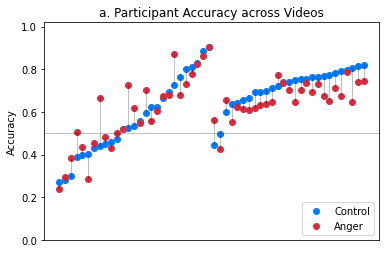

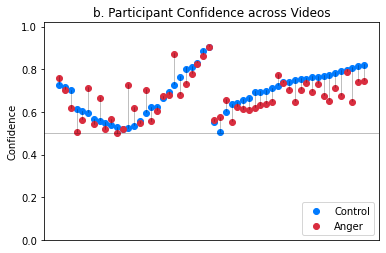

In [35]:
def video2(df2, s, rounder=1):
    df2 = df2[(df2.pass_check_binary==1) & (df2.video!="v2attentioncheck.mp4")]
    if s == "assignment":
        g = pd.DataFrame(df2[(df2.guess_round==rounder)].groupby(["video","assignment"])['score','fake',"p"].mean()).reset_index()
    else:
        g = pd.DataFrame(df2[(df2.guess_round==rounder)].groupby(["video","treatment_x"])['score','fake',"p"].mean()).reset_index()
    g.columns = ['video', 'assignment', 'h_score', 'fake', 'c_score']
    g["confidence"] = np.abs(g.h_score-.5)
    g.loc[(g.fake == 0),'c_score']=1-g.c_score    
    gfrank=pd.DataFrame(g[g.assignment=="control"].groupby("fake").h_score.rank(method="first"))
    print(gfrank.columns)
    gfrank.columns = ["ranker"]
    g0 = pd.merge(g,gfrank,left_index=True, right_index=True)
    g0=g0[["video","ranker"]]
    g = pd.merge(g,g0,on="video")
    g.loc[(g.fake == 0),'ranker']=27+g.ranker
    return g
g = video2(df2, "emotion", 1)
fig, ax1 = plt.subplots()
ax1.scatter(g[(g.assignment=="control")].ranker,g[(g.assignment=="control")].h_score, color=palette1, label="Control")
ax1.scatter(g[(g.assignment=="anger")].ranker,g[(g.assignment=="anger")].h_score, color=palette5, label="Anger")
# plt.scatter(g[(g.assignment=="control") & (g.fake==0)].ranker,g[(g.assignment=="control") & (g.fake==0)].h_score, color=palette1, marker="^", label="Control (Real)")
# plt.scatter(g[(g.assignment=="anger") & (g.fake==0)].ranker,g[(g.assignment=="anger") & (g.fake==0)].h_score, color=palette5, marker="^", label="Anger (Real)")
plt.ylabel('Accuracy')
# plt.xlabel('Video Index')
plt.xticks([])
plt.ylim(0,1.02)
ax1.axhline(y=0.5, xmin=0.0, xmax=1.0, color="black",linewidth=.5, alpha=.5)
for i in g.video.unique():
    temp = g[g.video==i]
    r = temp[temp.assignment=="control"]["ranker"]
    c = temp[temp.assignment=="control"]["h_score"]
    a = temp[temp.assignment=="anger"]["h_score"]
    mini = min(float(a),float(c))
    maxi = max(float(a),float(c))
    ax1.axvline(x=float(r), ymin=mini-.01, ymax=maxi-.01, color="black",linewidth=.5, alpha=.5)
plt.legend(prop={'size': 10}, loc="lower right")
# for i in g.iterrows():
# #         print(i[1]["g1_score_y"],i[1]["g1_score_x"],i[1]["c_score"])
#         ax1.axvline(x=i[1]["g1_score_y"], ymin=i[1]["g1_score_x"]-.01, ymax=i[1]["c_score"]-.01, color="black",linewidth=.5, alpha=.5)
plt.title("a. Participant Accuracy across Videos")
plt.savefig("Anger.eps",dpi=600)

g = video2(df2, "emotion", 1)
fig, ax1 = plt.subplots()
ax1.scatter(g[(g.assignment=="control")].ranker,.5+g[(g.assignment=="control")].confidence, color=palette1, label="Control")
ax1.scatter(g[(g.assignment=="anger")].ranker,.5+g[(g.assignment=="anger")].confidence, color=palette5, label="Anger")
# plt.scatter(g[(g.assignment=="control") & (g.fake==0)].ranker,g[(g.assignment=="control") & (g.fake==0)].h_score, color=palette1, marker="^", label="Control (Real)")
# plt.scatter(g[(g.assignment=="anger") & (g.fake==0)].ranker,g[(g.assignment=="anger") & (g.fake==0)].h_score, color=palette5, marker="^", label="Anger (Real)")
plt.ylabel('Confidence')
# plt.xlabel('Video Index')
plt.xticks([])
plt.ylim(0,1.02)
ax1.axhline(y=0.5, xmin=0.0, xmax=1.0, color="black",linewidth=.5, alpha=.5)
for i in g.video.unique():
    temp = g[g.video==i]
    r = temp[temp.assignment=="control"]["ranker"]
    c = .5+temp[temp.assignment=="control"]["confidence"]
    a = .5+temp[temp.assignment=="anger"]["confidence"]
    mini = min(float(a),float(c))
    maxi = max(float(a),float(c))
    ax1.axvline(x=float(r), ymin=mini-.01, ymax=maxi-.01, color="black",linewidth=.5, alpha=.5)
plt.legend(prop={'size': 10}, loc="lower right")
# for i in g.iterrows():
# #         print(i[1]["g1_score_y"],i[1]["g1_score_x"],i[1]["c_score"])
#         ax1.axvline(x=i[1]["g1_score_y"], ymin=i[1]["g1_score_x"]-.01, ymax=i[1]["c_score"]-.01, color="black",linewidth=.5, alpha=.5)
plt.title("b. Participant Confidence across Videos")
plt.savefig("Anger_Confidence.eps",dpi=600)


In [36]:
print((df2[(df2.guess_round==1) & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.video!="v2attentioncheck.mp4")].guess_int>50).sum())
print((df2[(df2.guess_round==1) & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.video!="v2attentioncheck.mp4")].guess_int<50).sum())

2246
3015


In [37]:
cm_2p = df2[(df2.guess_round==1) & (df2.video!="Putin_10s_b.mp4") & (df2.video!="Putin_10s_a.mp4") 
    & (df2.video!="Kim_10s_b.mp4") & (df2.video!="Kim_10s_a.mp4") & (df2.video!="v2attentioncheck.mp4")]

cm_2i = df2_x[(df2_x.guess_round==1) & (df2_x.video!="Putin_10s_b.mp4") & (df2_x.video!="Putin_10s_a.mp4") 
    & (df2_x.video!="Kim_10s_b.mp4") & (df2_x.video!="Kim_10s_a.mp4") & (df2_x.video!="v2attentioncheck.mp4")]

In [38]:
tn, fp, fn, tp = confusion_matrix(cm_2p[(cm_2p.guess_int!=50)].guess_int>50,cm_2p[(cm_2p.guess_int!=50)].fake).ravel()

In [39]:
x = []
y = []
z = []
for i in cm_2p.assignment.unique():
    z.append(i)
    tn, fp, fn, tp = confusion_matrix(cm_2p[(cm_2p.assignment==i) & (cm_2p.guess_int!=50)].fake, cm_2p[(cm_2p.assignment==i) & (cm_2p.guess_int!=50)].guess_int>50).ravel()
    print(cm_2p[(cm_2p.assignment==i) & (cm_2p.guess_int==50)].shape)
    x.append([tp,fn,(tp)/(tp+fn),fp,tn,(tn)/(tn+fp),(tp)/(tp+fp),(tn)/(tn+fn),(tp+tn)/(tp+tn+fp+fn)])
    tn, fp, fn, tp = confusion_matrix(cm_2i[(cm_2i.assignment==i) & (cm_2i.guess_int!=50)].fake, cm_2i[(cm_2i.assignment==i) & (cm_2i.guess_int!=50)].guess_int>50).ravel()
    print(cm_2i[(cm_2i.assignment==i) & (cm_2i.guess_int==50)].shape)

    y.append([tp,fn,(tp)/(tp+fn),fp,tn,(tn)/(tn+fp),(tp)/(tp+fp),(tn)/(tn+fn),(tp+tn)/(tp+tn+fp+fn)])
for i in cm_2p.treatment_x.unique():
    z.append("emo+{}".format(i))
    print(cm_2p[(cm_2p.treatment_x==i) & (cm_2p.guess_int==50)].shape)
    tn, fp, fn, tp = confusion_matrix(cm_2p[(cm_2p.treatment_x==i) & (cm_2p.guess_int!=50)].fake, cm_2p[(cm_2p.treatment_x==i) & (cm_2p.guess_int!=50)].guess_int>50).ravel()
    x.append([tp,fn,(tp)/(tp+fn),fp,tn,(tn)/(tn+fp),(tp)/(tp+fp),(tn)/(tn+fn),(tp+tn)/(tp+tn+fp+fn)])
    
for i in range(0,6):
    print("{}: prolific".format(z[i]))
    print(x[i][0:3])
    print(x[i][3:6])
    print(x[i][6:9])
    if i<4:
        print("{}: internet".format(z[i]))
        print(y[i][0:3])
        print(y[i][3:6])
        print(y[i][6:9])


(186, 124)
(1795, 39)
(60, 124)
(627, 39)
(65, 124)
(653, 39)
(62, 124)
(638, 39)
(218, 124)
(155, 124)
control: prolific
[792, 525, 0.6013667425968109]
[333, 984, 0.7471526195899773]
[0.704, 0.6520874751491054, 0.6742596810933941]
control: internet
[8690, 4140, 0.6773187840997662]
[2824, 9814, 0.7765469219813261]
[0.7547333680736494, 0.703310878601118, 0.7265588189100047]
misalignment: prolific
[211, 213, 0.49764150943396224]
[123, 286, 0.6992665036674817]
[0.6317365269461078, 0.5731462925851704, 0.5966386554621849]
misalignment: internet
[2427, 1779, 0.5770328102710414]
[1135, 2932, 0.7209245143840669]
[0.6813587871982033, 0.6223731691785184, 0.6477698537410854]
inversion: prolific
[245, 164, 0.5990220048899756]
[163, 296, 0.644880174291939]
[0.6004901960784313, 0.6434782608695652, 0.6232718894009217]
inversion: internet
[2688, 1440, 0.6511627906976745]
[1282, 2745, 0.6816488701266451]
[0.6770780856423174, 0.6559139784946236, 0.6662170447578173]
eye_occlusion: prolific
[250, 210, 0.5

# Treatment Effects

In [40]:
print(df2[df2.guess_round==1].assignment.value_counts())
print(df2[df2.guess_round==1].treatment_x.value_counts())

control            3044
eye_occlusion      1064
inversion          1012
misalignment        966
attention_check     304
Name: assignment, dtype: int64
control    3489
anger      2901
Name: treatment_x, dtype: int64


In [41]:
computer = pd.read_csv(model_performance_csv)
computer = computer[computer.video.str.contains("10s")==False]
print(computer.control_score.mean(),computer.inversion_score.mean(),stats.ttest_ind(computer.control_score,computer.inversion_score)[1])
print(computer.control_score.mean(),computer.misalignment_score.mean(),stats.ttest_ind(computer.control_score,computer.misalignment_score)[1])
print(computer.control_score.mean(),computer.eye_occlusion_score.mean(),stats.ttest_ind(computer.control_score,computer.eye_occlusion_score)[1])
computer.columns = ['video', 'fake', 'htcomputer_correct_guess', 'ht1',
       'ht2', 'ht3', 'ht4']
computer = computer[['video', 'fake', 'ht1',
       'ht2', 'ht3', 'ht4']]
print(computer.columns)

c = pd.wide_to_long(computer, stubnames='ht', i=['video','fake'], j='assign').reset_index()
c["treatment"] = "control"
c.loc[(c["assign"]==2),"treatment"]= "inversion"
c.loc[(c["assign"]==3),"treatment"]= "misalignment"
c.loc[(c["assign"]==4),"treatment"]= "eye_occlusion"
c["control"] = c["assign"]==1
c["inversion"] = (c["assign"]==2).astype(int)
c["misalignment"] = (c["assign"]==3).astype(int)
c["eye_occlusion"] = (c["assign"]==4).astype(int)
c["score"]= c['ht']
print(c.columns)
c["guess"] = c.fake
c.loc[(c.score < .5),'guess']= -1*(c.guess-1)
c.loc[(c.score == .5),'guess']= 5050

0.8134596252441406 0.69278076171875 0.0056485407505060346
0.8134596252441406 0.8241441345214844 0.8008442537894884
0.8134596252441406 0.8105055236816406 0.9483905241331909
Index(['video', 'fake', 'ht1', 'ht2', 'ht3', 'ht4'], dtype='object')
Index(['video', 'fake', 'assign', 'ht', 'treatment', 'control', 'inversion',
       'misalignment', 'eye_occlusion', 'score'],
      dtype='object')


In [42]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
exp2a = exp2a[(exp2a.video!="Putin_10s_b.mp4") & (exp2a.video!="Putin_10s_a.mp4") 
    & (exp2a.video!="Kim_10s_b.mp4") & (exp2a.video!="Kim_10s_a.mp4") & (exp2a.video!="v2attentioncheck.mp4")]
exp2b = exp2b[(exp2b.video!="Putin_10s_b.mp4") & (exp2b.video!="Putin_10s_a.mp4") 
    & (exp2b.video!="Kim_10s_b.mp4") & (exp2b.video!="Kim_10s_a.mp4") & (exp2b.video!="v2attentioncheck.mp4")]
# print(exp2a.video.unique())
fixed_effects = pd.get_dummies(exp2a.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c,c,c[c.fake==0],c[c.fake==1]]):
    if index<3:
        columns = ["misalignment","eye_occlusion","inversion", "anger"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    elif index<6:
        columns = ["misalignment","eye_occlusion","inversion"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    else:
        columns = ["inversion", "misalignment","eye_occlusion"]
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit()
    x.append(res)
#     print(index)
#     print(len(x))


participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique(), 0,0,0]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50), sum(c.guess==0), sum(c[c.fake==0].guess==0), sum(c[c.fake==1].guess==0)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50), sum(c.guess==1), sum(c[c.fake==0].guess==1), sum(c[c.fake==1].guess==1)]
fiftyfifty_guesses = [sum(e2a_a.guess_int==50), sum(e2a_b.guess_int==50), sum(e2a_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50), sum(c.guess==5050), sum(c[c.fake==0].guess==5050), sum(c[c.fake==1].guess==5050)]
    
print(len(x))
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5],x[6],x[7],x[8]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet", "Computer"], [3,3,3])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)
stargazer.add_line('Number of Unique Videos', [50,25,25,50,25,25,50,25,25] )

HTML(stargazer.render_html())

9


In [43]:
# exp2a = pd.read_csv(experiment1_prolific_csv)
# exp2b = pd.read_csv(experiment1_internet_csv)
# exp2a = exp2a[(exp2a.video!="Putin_10s_b.mp4") & (exp2a.video!="Putin_10s_a.mp4") 
#     & (exp2a.video!="Kim_10s_b.mp4") & (exp2a.video!="Kim_10s_a.mp4") & (exp2a.video!="v2attentioncheck.mp4")]
# exp2b = exp2b[(exp2b.video!="Putin_10s_b.mp4") & (exp2b.video!="Putin_10s_a.mp4") 
#     & (exp2b.video!="Kim_10s_b.mp4") & (exp2b.video!="Kim_10s_a.mp4") & (exp2b.video!="v2attentioncheck.mp4")]
# # print(exp2a.video.unique())
# fixed_effects = pd.get_dummies(exp2a.video)
# fe = fixed_effects.columns

# exp2a = exp2a[exp2a.seen>0]
# exp2b = exp2b[exp2b.seen>0]

# e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
# e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
# e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

# x = []


# fixed_effects = pd.get_dummies(exp2b.video)
# fe = fixed_effects.columns
# exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


# e2b_a = exp2b[exp2b.guess_round==1]
# e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
# e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
# x=[]
# for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c,c,c[c.fake==0],c[c.fake==1]]):
#     if index<3:
#         columns = ["misalignment","eye_occlusion","inversion", "anger"]
# #         for item in fe:
# #             columns.append(item)
#         res = sm.OLS(i['score'],
#               sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
#              ).fit(cov_type='cluster', 
#                     cov_kwds={'groups': i.prolific_pid})
#     elif index<6:
#         columns = ["misalignment","eye_occlusion","inversion"]
# #         for item in fe:
# #             columns.append(item)
#         res = sm.OLS(i['score'],
#               sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
#              ).fit(cov_type='cluster', 
#                     cov_kwds={'groups': i.user_id})
#     else:
#         columns = ["inversion", "misalignment","eye_occlusion"]
#         res = sm.OLS(i['score'],
#               sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
#              ).fit()
#     x.append(res)
# #     print(index)
# #     print(len(x))


# participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
#                 e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique(), 0,0,0]
# real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
#                 sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50), sum(c.guess==0), sum(c.guess==0), sum(c.guess==0)]
# fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
#                 sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50), sum(c.guess==1), sum(c.guess==1), sum(c.guess==1)]
# fiftyfifty_guesses = [sum(e2a_a.guess_int==50), sum(e2a_b.guess_int==50), sum(e2a_c.guess_int==50),
#                       sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50), sum(c.guess==5050), sum(c.guess==5050), sum(c.guess==5050)]
    
# print(len(x))
# stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5],x[6],x[7],x[8]])
# stargazer.title("Table 1")
# stargazer.custom_columns(['Prolific', "Internet", "Computer"], [3,3,3])
# stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
# stargazer.rename_covariates({'anger': 'Anger', 
#                              'const': 'Constant',
#                              'eye_occlusion': 'Eye Occlusion',
#                              'inversion': 'Inversion',
#                              'misalignment': 'Misalignment',
#                               'anger': "Anger"})
# stargazer.significant_digits(3)
# stargazer.show_degrees_of_freedom(False)
# stargazer.add_line('Number of Participants', participants )
# stargazer.add_line('Number of Guesses (Real)', real_guesses)
# stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
# stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)
# stargazer.add_line('Number of Unique Videos', [50,50,50,50,50,50,50,50,50] )

# HTML(stargazer.render_html())

In [44]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
exp2a = exp2a[(exp2a.video!="Putin_10s_b.mp4") & (exp2a.video!="Putin_10s_a.mp4") 
    & (exp2a.video!="Kim_10s_b.mp4") & (exp2a.video!="Kim_10s_a.mp4") & (exp2a.video!="v2attentioncheck.mp4")]
exp2b = exp2b[(exp2b.video!="Putin_10s_b.mp4") & (exp2b.video!="Putin_10s_a.mp4") 
    & (exp2b.video!="Kim_10s_b.mp4") & (exp2b.video!="Kim_10s_a.mp4") & (exp2b.video!="v2attentioncheck.mp4")]
print(exp2a.video.unique())
fixed_effects = pd.get_dummies(exp2a.video)
fe = fixed_effects.columns

exp2a["confidence"] = .5 + np.abs(exp2a.score-.5)
exp2b["confidence"] = .5 + np.abs(exp2b.score-.5)

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c, e2b_a, e2b_b,e2b_c,c,c[c.fake==0],c[c.fake==1]]):
    if index<3:
        columns = ["misalignment","eye_occlusion","inversion", "anger"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['confidence'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    elif index<6:
        columns = ["misalignment","eye_occlusion","inversion"]
        for item in fe:
            columns.append(item)
        res = sm.OLS(i['confidence'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.user_id})
    else:
        columns = ["misalignment","eye_occlusion","inversion"]
        res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit()
    x.append(res)
    print(len(x))

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique(), 0,0,0]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50), sum(c.guess==0), sum(c.guess==0), sum(c.guess==0)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50), sum(c.guess==1), sum(c.guess==1), sum(c.guess==1)]
fiftyfifty_guesses = [sum(e2a_a.guess_int==50), sum(e2a_b.guess_int==50), sum(e2a_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50), sum(c.guess==5050), sum(c.guess==5050), sum(c.guess==5050)]
    
print(len(x))
stargazer = Stargazer([x[0],x[1],x[2], x[3],x[4],x[5],x[6],x[7],x[8]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific', "Internet", "Computer"], [3,3,3])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment',
                              'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants )
stargazer.add_line('Number of Guesses (Real)', real_guesses)
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)
stargazer.add_line('Number of Unique Videos', [50,50,50,50,50,50,50,50,50] )

HTML(stargazer.render_html())

['5201.mp4' '6216.mp4' '7356.mp4' '6597.mp4' '5142.mp4' '7849.mp4'
 '7837.mp4' '5908.mp4' '7968.mp4' '7723.mp4' '4122.mp4' '5843.mp4'
 '7298.mp4' '6660.mp4' '6564.mp4' '5471.mp4' '6592.mp4' '6189.mp4'
 '6651.mp4' '5534.mp4' '5319.mp4' '4250.mp4' '5785.mp4' '4712.mp4'
 '6251.mp4' '6561.mp4' '7679.mp4' '7693.mp4' '4742.mp4' '4135.mp4'
 '4110.mp4' '4261.mp4' '6537.mp4' '6153.mp4' '7324.mp4' '6642.mp4'
 '4555.mp4' '4704.mp4' '5370.mp4' '7494.mp4' '5844.mp4' '4121.mp4'
 '7439.mp4' '4545.mp4' '6575.mp4' '7737.mp4' '7266.mp4' '6676.mp4'
 '4757.mp4' '7957.mp4']
1
2
3
4
5
6
7
8
9
9


In [45]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
exp2a = exp2a[(exp2a.video!="Putin_10s_b.mp4") & (exp2a.video!="Putin_10s_a.mp4") 
    & (exp2a.video!="Kim_10s_b.mp4") & (exp2a.video!="Kim_10s_a.mp4") & (exp2a.video!="v2attentioncheck.mp4")]
exp2b = exp2b[(exp2b.video!="Putin_10s_b.mp4") & (exp2b.video!="Putin_10s_a.mp4") 
    & (exp2b.video!="Kim_10s_b.mp4") & (exp2b.video!="Kim_10s_a.mp4") & (exp2b.video!="v2attentioncheck.mp4")]

# exp2b = exp2b[(exp2b.video=="Putin_10s_b.mp4") | (exp2b.video=="Putin_10s_a.mp4") 
#     | (exp2b.video=="Kim_10s_b.mp4") | (exp2b.video=="Kim_10s_a.mp4") | (exp2b.video=="v2attentioncheck.mp4")]


print(exp2b.video.unique())
fixed_effects = pd.get_dummies(exp2a.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==1) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==1]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2b_a]):
    for j in i.video.unique():
        print(j)
        columns = ["misalignment","eye_occlusion","inversion"]
        res = sm.OLS(i[i.video==j]['score'],
              sm.add_constant(i[i.video==j][columns]), M=sm.robust.norms.HuberT()
             ).fit(
#             cov_type='cluster', 
#             cov_kwds={'groups': i[i.video==j].prolific_pid}
        )
        x.append(res)
        print(len(x))
print("a")
print(len(x))
stargazer = Stargazer([x[0],x[1],x[2],x[3]])
stargazer.title("Table 1")
# stargazer.custom_columns(['Prolific', "Internet", "Computer"], [3,3,3])
# stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", "anger"])
# stargazer.rename_covariates({'anger': 'Anger', 
#                              'const': 'Constant',
#                              'eye_occlusion': 'Eye Occlusion',
#                              'inversion': 'Inversion',
#                              'misalignment': 'Misalignment',
#                               'anger': "Anger"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
# stargazer.add_line('Number of Participants', participants )
# stargazer.add_line('Number of Guesses (Real)', real_guesses)
# stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses)
# stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses)
# stargazer.add_line('Number of Unique Videos', [50,50,50,50,50,50,50,50,50] )

HTML(stargazer.render_html())

['7849.mp4' '5843.mp4' '7439.mp4' '7298.mp4' '7957.mp4' '7837.mp4'
 '6676.mp4' '4135.mp4' '6597.mp4' '5471.mp4' '6153.mp4' '6189.mp4'
 '4712.mp4' '5785.mp4' '6251.mp4' '7266.mp4' '6575.mp4' '6651.mp4'
 '4122.mp4' '7679.mp4' '5201.mp4' '7693.mp4' '4704.mp4' '5142.mp4'
 '7494.mp4' '6564.mp4' '5319.mp4' '6660.mp4' '6561.mp4' '6216.mp4'
 '5534.mp4' '6642.mp4' '6537.mp4' '7356.mp4' '4110.mp4' '6592.mp4'
 '7968.mp4' '5908.mp4' '5844.mp4' '4742.mp4' '4545.mp4' '4250.mp4'
 '7723.mp4' '7737.mp4' '4757.mp4' '4555.mp4' '4261.mp4' '7324.mp4'
 '4121.mp4' '5370.mp4']
7849.mp4
1
5843.mp4
2
7439.mp4
3
7298.mp4
4
7957.mp4
5
7837.mp4
6
6676.mp4
7
4135.mp4
8
6597.mp4
9
5471.mp4
10
6153.mp4
11
6189.mp4
12
4712.mp4
13
5785.mp4
14
6251.mp4
15
7266.mp4
16
6575.mp4
17
6651.mp4
18
4122.mp4
19
7679.mp4
20
5201.mp4
21
7693.mp4
22
4704.mp4
23
5142.mp4
24
7494.mp4
25
6564.mp4
26
5319.mp4
27
6660.mp4
28
6561.mp4
29
6216.mp4
30
5534.mp4
31
6642.mp4
32
6537.mp4
33
7356.mp4
34
4110.mp4
35
6592.mp4
36
7968.mp4
37
5908.

In [46]:
print(e2b_a.groupby("video").user_id.count().max())
print(e2b_a.groupby("video").user_id.count().min())

1168
945


In [47]:
mis = []
eye = []
inv = []
any1 = []
for i in x:
    if i.params[1]<0:
        mis.append(i.pvalues[1]<.01)
    if i.params[2]<0:
        eye.append(i.pvalues[2]<.01)
    if i.params[3]<0:
        inv.append(i.pvalues[3]<.01)
    any1.append(((i.pvalues[1]<.01)&(i.params[1]<0))|((i.pvalues[2]<.01)&(i.params[2]<0))|((i.pvalues[3]<.01)&(i.params[3]<0)))

In [48]:
print(sum(mis))
print(sum(eye))
print(sum(inv))
print(sum(any1))

24
15
20
29


In [49]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2a = exp2a.sort_values(["prolific_pid","video","guess_round"])
exp2a["r1"] = exp2a.groupby(["prolific_pid","video"])["guess_int"].shift(1)
exp2a = exp2a.dropna()
exp2a["cc"] = np.abs(exp2a["guess_int"] - exp2a["r1"])
exp2a["cc2"] = np.abs(exp2a["guess_int"] - exp2a["r1"])
exp2a.loc[(exp2a["fake"]==1),"cc2"]= exp2a["guess_int"] - exp2a["r1"]
exp2a.loc[(exp2a["fake"]==0),"cc2"]= exp2a["r1"] - exp2a["guess_int"]
exp2a[["prolific_pid","video","guess_round","guess_int","r1", "fake", "p"]][exp2a.guess_int!=exp2a.r1]

,prolific_pid,video,guess_round,guess_int,r1,fake,p
10481,546e3778fdf99b2bc7ebcff6,5319.mp4,2,92,10.0,1,0.989258
10479,546e3778fdf99b2bc7ebcff6,6592.mp4,2,53,78.0,0,0.500000
10477,546e3778fdf99b2bc7ebcff6,6660.mp4,2,88,7.0,1,0.958984
10475,546e3778fdf99b2bc7ebcff6,7723.mp4,2,18,82.0,0,0.106262
10469,546e3778fdf99b2bc7ebcff6,Kim_10s_a.mp4,2,51,77.0,1,0.018000
...,...,...,...,...,...,...,...
3024,5fa8b4123a3f0d7a4aab8ef3,v2attentioncheck.mp4,2,100,50.0,1,0.012000
5907,5fa941f4897b8d0670476392,4712.mp4,2,27,79.0,0,0.014999
5891,5fa941f4897b8d0670476392,5908.mp4,2,27,50.0,0,0.027756
5909,5fa941f4897b8d0670476392,6251.mp4,2,23,75.0,0,0.017090


In [50]:
exp2a = pd.read_csv(experiment1_prolific_csv)
exp2b = pd.read_csv(experiment1_internet_csv)
exp2a = exp2a[exp2a.video!='Kim_10s_a.mp4']
exp2a = exp2a[exp2a.video!='Kim_10s_b.mp4']
exp2a = exp2a[exp2a.video!='Putin_10s_a.mp4']
exp2a = exp2a[exp2a.video!='Putin_10s_b.mp4']

# exp2a = exp2a[(exp2a.video=='7837.mp4') | (exp2a.video=='5844.mp4') | (exp2a.video=='6153.mp4')]
# exp2a = exp2a[(exp2a.video=='4135.mp4') | 
#               (exp2a.video=='6592.mp4') | 
#               (exp2a.video=='6561.mp4') |
#               (exp2a.video=='4555.mp4') |
#               (exp2a.video=='7849.mp4') |
#               (exp2a.video=='7356.mp4') |
#               (exp2a.video=='7968.mp4')
#              ]

exp2a = exp2a[exp2a.video!='7837.mp4']
exp2a = exp2a[exp2a.video!='5844.mp4']
exp2a = exp2a[exp2a.video!='6153.mp4']
exp2a = exp2a[exp2a.video!='4135.mp4']
exp2a = exp2a[exp2a.video!='6592.mp4']
exp2a = exp2a[exp2a.video!='6561.mp4']
exp2a = exp2a[exp2a.video!='4555.mp4']
exp2a = exp2a[exp2a.video!='7849.mp4']
exp2a = exp2a[exp2a.video!='7356.mp4']
exp2a = exp2a[exp2a.video!='7968.mp4']


exp2a = exp2a.sort_values(["prolific_pid","video","guess_round"])
# exp2a["r1"] = exp2a.groupby(["prolific_pid","video"])["guess_int"].shift(1)
# exp2a = exp2a.dropna()
# exp2a["cc"] = np.abs(exp2a["guess_int"] - exp2a["r1"])
# exp2a["cc2"] = np.abs(exp2a["guess_int"] - exp2a["r1"])
# exp2a.loc[(exp2a["fake"]==1),"cc2"]= exp2a["guess_int"] - exp2a["r1"]
# exp2a.loc[(exp2a["fake"]==0),"cc2"]= exp2a["r1"] - exp2a["guess_int"]

exp2a["r1_x"] = exp2a.groupby(["prolific_pid","video"])["human_correct_guess"].shift(1)
exp2a = exp2a.dropna()
exp2a["cc2_x"] = 3
exp2a.loc[(exp2a["human_correct_guess"]==0) & (exp2a["r1_x"]==0),"cc2_x"]= 0
exp2a.loc[(exp2a["human_correct_guess"]==1) & (exp2a["r1_x"]==0),"cc2_x"]= 1
exp2a.loc[(exp2a["human_correct_guess"]==0) & (exp2a["r1_x"]==1),"cc2_x"]= -1
exp2a.loc[(exp2a["human_correct_guess"]==1) & (exp2a["r1_x"]==1),"cc2_x"]= 0
print(exp2a.cc2_x.value_counts())
print(exp2a.shape)
print(exp2a[["video","p","r1_x","guess_int","human_correct_guess", "fake"]][exp2a.human_correct_guess!=exp2a.r1_x].head(10))


fixed_effects = pd.get_dummies(exp2a.video)
fe = fixed_effects.columns

exp2a = exp2a[exp2a.seen>0]
exp2b = exp2b[exp2b.seen>0]

e2a_a = exp2a[(exp2a.guess_round==2) & (exp2a.pass_check_binary==1)]
e2a_b = exp2a[(exp2a.fake==0) & (exp2a.guess_round==2) & (exp2a.pass_check_binary==1)]
e2a_c = exp2a[(exp2a.fake==1) & (exp2a.guess_round==2) & (exp2a.pass_check_binary==1)]

x = []


fixed_effects = pd.get_dummies(exp2b.video)
fe = fixed_effects.columns
exp2b = pd.merge(exp2b,fixed_effects, left_index=True, right_index=True)


e2b_a = exp2b[exp2b.guess_round==2]
e2b_b = exp2b[(exp2b.fake==0) & (exp2b.guess_round==1)]
e2b_c = exp2b[(exp2b.fake==1) & (exp2b.guess_round==1)]
x=[]
for index, i in enumerate([e2a_a, e2a_b,e2a_c]):
    if index<3:
        columns = ["anger"] # "inversion","misalignment","eye_occlusion"
#         for item in fe:
#             columns.append(item)
        print(index)
        res = sm.OLS(i['cc2_x'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
#     else:
#         columns = ["misalignment","eye_occlusion","inversion"]
# #         for item in fe:
# #             columns.append(item)
#         res = sm.OLS(i['cc2'],
#               sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
#              ).fit(cov_type='cluster', 
#                     cov_kwds={'groups': i.user_id})
    x.append(res)

participants = [e2a_a.prolific_pid.nunique(),e2a_b.prolific_pid.nunique(),e2a_c.prolific_pid.nunique(),
                e2b_a.user_id.nunique(),e2b_b.user_id.nunique(),e2b_c.user_id.nunique()]
real_guesses = [sum(e2a_a.guess_int<50), sum(e2a_b.guess_int<50), sum(e2a_c.guess_int<50),
                sum(e2b_a.guess_int<50), sum(e2b_b.guess_int<50), sum(e2b_c.guess_int<50)]
fake_guesses = [sum(e2a_a.guess_int>50), sum(e2a_b.guess_int>50), sum(e2a_c.guess_int>50),
                sum(e2b_a.guess_int>50), sum(e2b_b.guess_int>50), sum(e2b_c.guess_int>50)]
fiftyfifty_guesses = [sum(e2a_a.guess_int==50), sum(e2a_b.guess_int==50), sum(e2a_c.guess_int==50),
                      sum(e2b_a.guess_int==50), sum(e2b_b.guess_int==50), sum(e2b_c.guess_int==50)]
    
   
    
    
stargazer = Stargazer([x[0],x[1],x[2]])  #x[3],x[4],x[5]])
stargazer.title("Table 1")
stargazer.custom_columns(['Prolific'], [3])
stargazer.covariate_order(['const', "anger",])  # ,"inversion","misalignment","eye_occlusion",
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'misalignment': "Misalignment",
                            "eye_occlusion": "Eye Occlusion",
                            "inversion": "Inversion"})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', participants[0:3] )
stargazer.add_line('Number of Guesses (Real)', real_guesses[0:3])
stargazer.add_line('Number of Guesses (Deepfake)', fake_guesses[0:3])
stargazer.add_line('Number of Guesses (50-50)', fiftyfifty_guesses[0:3])

HTML(stargazer.render_html())

 0    4089
 1     649
-1      48
Name: cc2_x, dtype: int64
(4786, 113)
          video         p   r1_x  guess_int  human_correct_guess  fake
10481  5319.mp4  0.989258  False         92                 True     1
10477  6660.mp4  0.958984  False         88                 True     1
10475  7723.mp4  0.106262  False         18                 True     0
3460   7266.mp4  0.986328  False         87                 True     1
11336  4110.mp4  0.745117  False         75                 True     1
11308  5142.mp4  0.615723  False         66                 True     1
11318  5843.mp4  0.985352  False         97                 True     1
11312  5908.mp4  0.027756  False         14                 True     0
11324  6537.mp4  0.979492  False         90                 True     1
11320  7298.mp4  0.630859  False         64                 True     1
0
1
2


In [51]:
x[1].pvalues

const    0.000002
anger    0.099525
dtype: float64

In [52]:
df2 = df2[df2.seen>0]
a1 = df2[df2.guess_round==1]
b1 = df2[(df2.fake==0) & (df2.guess_round==1)]
c1 = df2[(df2.fake==1) & (df2.guess_round==1)]
a2 = df2[(df2.guess_round==1) & (df2.pass_check_binary==1)]
b2 = df2[(df2.fake==0) & (df2.guess_round==1) & (df2.pass_check_binary==1)]
c2 = df2[(df2.fake==1) & (df2.guess_round==1) & (df2.pass_check_binary==1)]
a3 = df2[(df2.guess_round==2) & (df2.pass_check_binary==1)]
b3 = df2[(df2.fake==0) & (df2.guess_round==2) & (df2.pass_check_binary==1)]
c3 = df2[(df2.fake==1) & (df2.guess_round==2) & (df2.pass_check_binary==1)]
x = []
columns = ["misalignment","eye_occlusion","inversion","anger"]
for i in fe:
    columns.append(i)
for i in [a1, b1,c1,a2,b2,c2,a3,b3,c3]:
    res = sm.OLS(i['score'],
              sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()
             ).fit(
                    cov_type='cluster', 
                    cov_kwds={'groups': i.prolific_pid})
    x.append(res)
    
stargazer = Stargazer([x[0],x[1],x[2]])
stargazer.title("Round 1 (All Respondents)")
stargazer.custom_columns(['All', "Real", "DeepFake"], [1,1,1])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", 'anger'])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment'})
stargazer.significant_digits(3)
stargazer.show_degrees_of_freedom(False)
stargazer.add_line('Number of Participants', [a1.prolific_pid.nunique(),a1.prolific_pid.nunique(),a1.prolific_pid.nunique()])
stargazer.add_line('Number of Guesses (Real)', [sum(a1.guess_int<50), sum(b1.guess_int<50), sum(c1.guess_int<50)])
stargazer.add_line('Number of Guesses (Deepfake)', [sum(a1.guess_int>50), sum(b1.guess_int>50), sum(c1.guess_int>50)])
stargazer.add_line('Number of Guesses (Not sure)', [sum(a1.guess_int==50), sum(b1.guess_int==50), sum(c1.guess_int==50)])

HTML(stargazer.render_html())

In [53]:
stargazer = Stargazer([x[6],x[7],x[8]])
stargazer.title("Round 2 (Pass Attention Check)")
stargazer.custom_columns(['All', "Real", "DeepFake"], [1,1,1])
stargazer.covariate_order(['const','inversion',"misalignment","eye_occlusion", 'anger'])
stargazer.rename_covariates({'anger': 'Anger', 
                             'const': 'Constant',
                             'eye_occlusion': 'Eye Occlusion',
                             'inversion': 'Inversion',
                             'misalignment': 'Misalignment'})
stargazer.significant_digits(3)
stargazer.add_line('Number of Participants', [a3.prolific_pid.nunique(),b3.prolific_pid.nunique(),c3.prolific_pid.nunique()])

stargazer.show_degrees_of_freedom(False)
HTML(stargazer.render_html())

In [54]:
x[7].pvalues

const              0.000000e+00
misalignment       5.574441e-01
eye_occlusion      5.745655e-01
inversion          3.222083e-03
anger              2.457211e-01
4110.mp4           1.894151e-08
4121.mp4           3.699548e-02
4122.mp4           2.963316e-01
4135.mp4           4.564462e-02
4250.mp4           1.935823e-07
4261.mp4           7.523122e-03
4545.mp4           3.064811e-03
4555.mp4           2.201841e-01
4704.mp4           4.294976e-09
4712.mp4           7.878295e-02
4742.mp4           3.325452e-01
4757.mp4           2.918384e-06
5142.mp4           1.024982e-03
5201.mp4           9.259702e-06
5319.mp4           8.409105e-01
5370.mp4           3.685286e-05
5471.mp4           1.245379e-05
5534.mp4           1.892888e-02
5785.mp4           4.501531e-01
5843.mp4           1.607492e-01
5844.mp4           1.654256e-06
5908.mp4           1.275066e-06
6153.mp4           6.116733e-02
6189.mp4           1.747927e-02
6216.mp4           3.024000e-04
6251.mp4           2.316328e-03
6537.mp4